In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from locationHelper import LocationHelper
from preProcessingHelper import PreProcessRatings

from pandas.api.types import CategoricalDtype

from scipy.stats import  kruskal, anderson
import random


np.random.seed(42)

In [9]:
# helper functions
def get_rating_per_month(df: pd.DataFrame):
    months = np.sort(df["month"].unique())
    all_months_vals = []
    for m in months:
        month_list = [rating for rating in df[df["month"] == m]["rating"].values]
        all_months_vals.append(month_list)
    return all_months_vals

## Preprocessing
### Which data should we use for our investigation?

For the preprocessing we've written a [preProcessingHelper.py](src/utils/preProcessingHelper.py). We have a jupyter notebook [preProcessing.ipynb](test/preProcessing.ipynb) which shows our workflow to eventually get the preProcessingHelper.py


Additionally we've written a [locationHelper.py](src/utils/locationHelper.py), which adds the country and state codes to the reviews. For the part of the analysis that needs a corresponding location to the review, we assume that the location of the user that wrote the review is most likely the location where the review was written. If there is still time after our main tasks, this is something we could investigate further.

In [3]:
both_df = pd.read_csv("src/data/tims_data/beerAdvocateRatingsBothDatasets.csv") # dataset containing reviews and ratings

To make things easier and more robust to changes differences of rating systems that are eventually reflected in the rating, we took the decision to do our investigation for only one platform (and maybe do it for the other platform depending on how much time is left in the end of the project). As BeerAdvocate has more data compared to RateBeer and has more fine grained data, we concluded to go for BeerAdvocate in the US. BeerAdvocates data mainly stems from the US, which we can see on the map down below. Aditionally, we have a further partitioning in the states

In [27]:
ratings_count = both_df.groupby("country_code3").agg(nr_ratings=("country_code3", "count")).reset_index()
ratings_count["nr_ratings_log"] = np.log2(ratings_count["nr_ratings"]).replace(-np.inf, 0)

country_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
map = folium.Map(location=[10, 0], zoom_start=1.5)
cp = folium.Choropleth(geo_data=country_geo,
            data=ratings_count,
            columns=['country_code3', 'nr_ratings_log'],
            key_on='feature.id',
            fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
            legend_name="Nr. of ratings (log2 scale)",
            highlight=True

        ).add_to(map)

for s in cp.geojson.data['features']:
      if s['id'] in ratings_count['country_code3'].values:
            s['properties']['nr_ratings'] = (ratings_count[ratings_count["country_code3"] == s['id']]["nr_ratings"]).values[0].astype(str)
      else:
            s['properties']['nr_ratings'] = "0"
      
folium.GeoJsonTooltip(['name', "nr_ratings"]).add_to(cp.geojson)
folium.LayerControl().add_to(map)

map

In [4]:
# reduce our dataframe to data from US
both_df = both_df[both_df["country_code3"] == "USA"]

### Can we find special behaviour for some year?

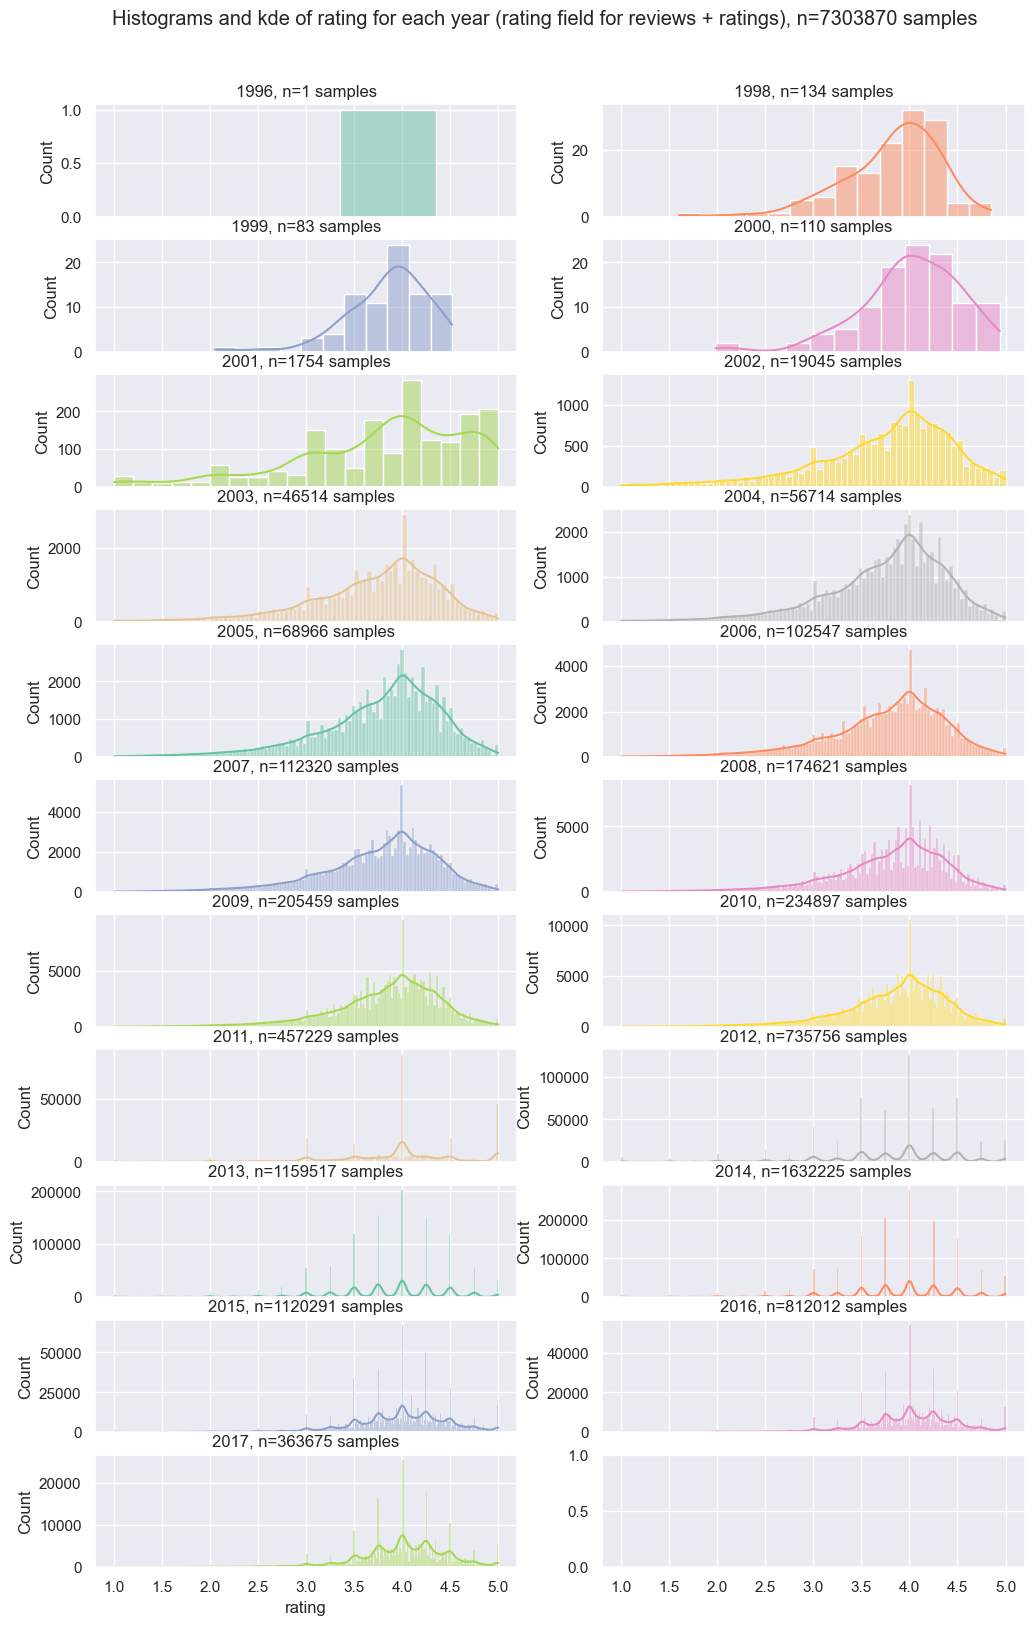

In [4]:
years = np.sort(both_df["year"].dropna().unique())
fig, ax = plt.subplots(int(np.ceil(len(years)/2)), 2, figsize= (12, 19), sharex=True)
ax = ax.flatten()
fig.suptitle(f"Histograms and kde of rating for each year (rating field for reviews + ratings), n={both_df.shape[0]} samples", y=0.93)
for i, year in enumerate(years):
    year_df = both_df[both_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i], color=palette[i%len(palette)])
    h.set_title(f'{int(year)}, n={year_df.shape[0]} samples')


Looking at the plots we see that starting from 2002 the number of ratings start to rise and is more similar to the other years. We conclude that most likely the rating system changed as well. To not let old data screw our results, we get rid of the data before 2002.

In [5]:
both_df = both_df[both_df["year"] >= 2002]
reviews_df = both_df[both_df["is_review"]]
ratings_df = both_df[~both_df["is_review"]]

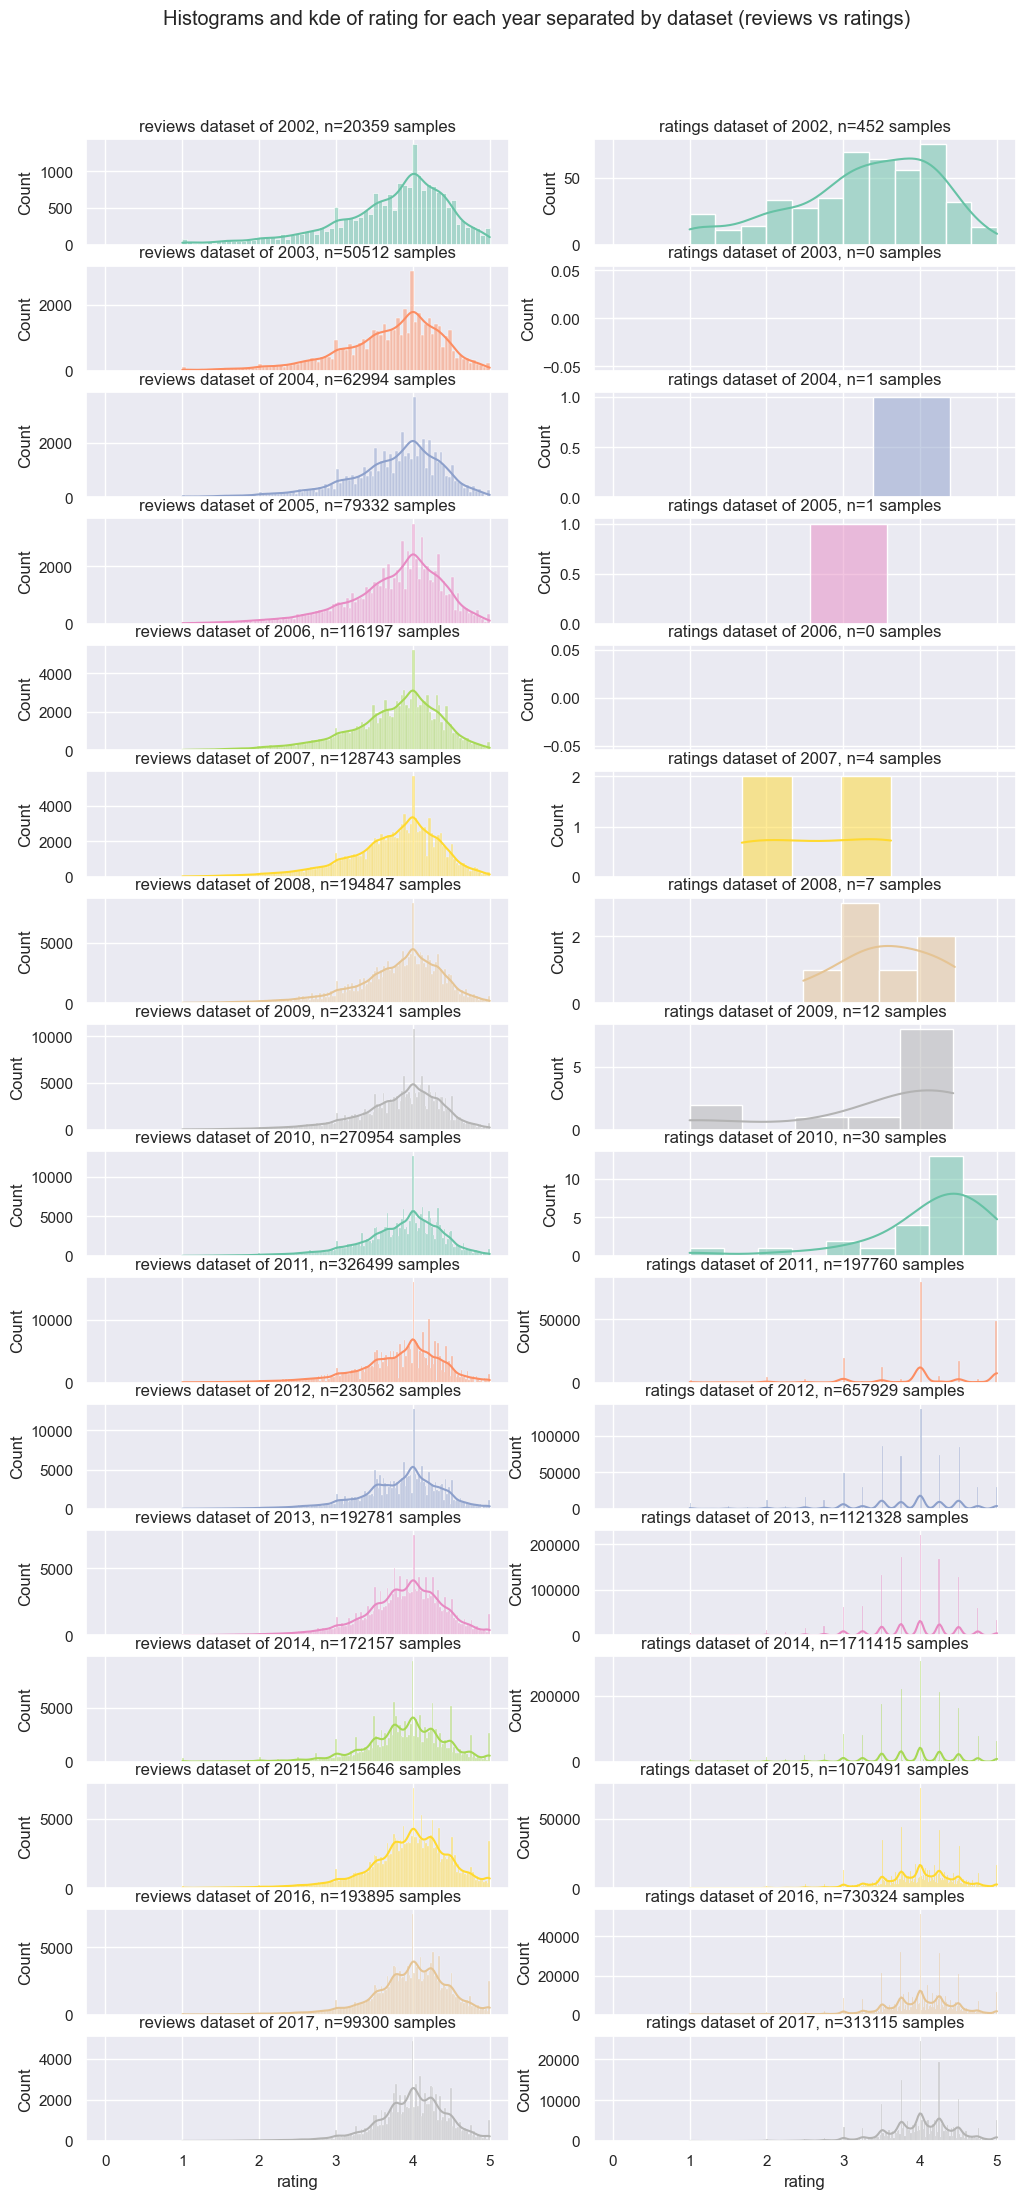

In [40]:
years = np.sort(reviews_df["year"].dropna().unique())
fig, ax = plt.subplots(int(len(years)), 2, figsize= (12, 26), sharex=True)

fig.suptitle(f"Histograms and kde of rating for each year separated by dataset (reviews vs ratings)", y=0.93)

# reviews
for i, year in enumerate(years):
    year_df = reviews_df[reviews_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][0], color=palette[i%len(palette)])
    h.set_title(f'reviews dataset of {int(year)}, n={year_df.shape[0]} samples')

# reviews
for i, year in enumerate(years):
    year_df = ratings_df[ratings_df["year"] == year]
    h = sns.histplot(year_df , x = "rating", kde=True, ax=ax[i][1], color=palette[i%len(palette)])
    h.set_title(f'ratings dataset of {int(year)}, n={year_df.shape[0]} samples')

Furthermore, there are two datasets: ratings and reviews. We conclude that these are two ways how people can record a beer review. Both datasets have a rating attribute $r \in [1, 5]$, which reflects the quality of a beer.
- In the reviews dataset, $r$ is calculated as a weighted mean over different attributes.
- In the rating dataset, $r$ is a continuous number (from 2011-2014, $r$ was discrete with steps of 0.25).

Until 2011, there were more reviews than ratings. From 2011 to 2017 there are a lot more ratings than reviews. We conclude to work with data from the reviews dataset. It's less data but, more importantly, it's more balanced over the years.

## 0. Intro: show that there is something going on!

This section shows that there are seasonal fluctuations and that it's worth investigating where they stem from. 

#### load the data

In [ ]:
ph = PreProcessRatings(platform="BeerAdvocate")
reviews_df = ph.get_dataframe(dataset="reviews", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style"])
reviews_df.to_csv("src/data/beerAdvocateReviews.csv", index=False)

In [6]:
reviews_df = pd.read_csv("src/data/beerAdvocateReviews.csv") # dataset containing reviews
reviews_df = reviews_df[(reviews_df["year"] >= 2002) & (reviews_df["country_code3"] >= "USA")]


Text(0.5, 1.0, 'Avg rating in the US over the period 2002 - 2017 with 95% confidence interval, n=2240430')

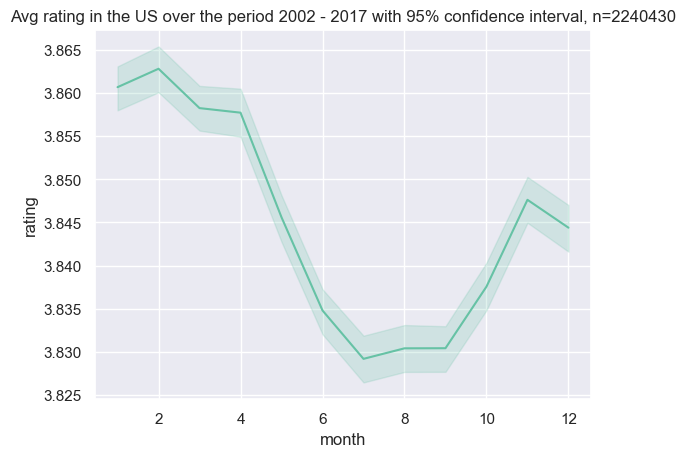

In [7]:
sns.lineplot(reviews_df, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating in the US over the period {reviews_df["year"].min()} - {reviews_df["year"].max()} with 95% confidence interval, n={reviews_df.shape[0]}')

It looks as if the world doesn't rate the beers the same over the year! Why could that be the case? We want to see if it's statistically relevant! 


First we want to see if we can assume normality. We chose Anderson-Darling Test over Shapiro-Wilk because of our huge sample size.

Anderson-Darling test to check for normality for month 1:
AndersonResult(statistic=np.float64(2746.054774901422), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.8606827589862713), scale=np.float64(0.5972202352409599))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 2:
AndersonResult(statistic=np.float64(2506.722981902567), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.862817498203195), scale=np.float64(0.5954146412276019))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Anderson-Darling test to check for normality for month 3:
AndersonResult(statistic=np.float64(2674.223614056624), critical_values=array([0.576, 0.656, 0.

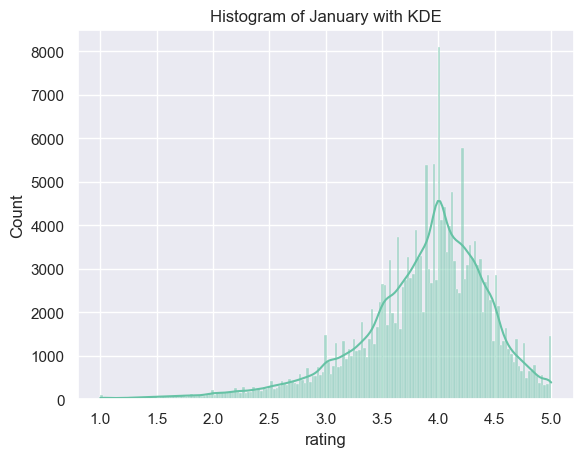

In [ ]:
monthly_ratings = get_rating_per_month(reviews_df)
h = sns.histplot(monthly_ratings[0], kde=True)
h.set_title("Histogram of January with KDE")
h.set_xlabel("rating")

for i, ratings in enumerate(monthly_ratings):
    print(f"Anderson-Darling test to check for normality for month {i+1}:")
    print(anderson(ratings, dist="norm"))
    print()

We can see that, for each month, the statistics exceeds the critical value by far (for each significance level). Therefore we'll reject the null hypothesis and don't assume normality which is not surprising by looking at the histogram for the ratings of january. 

Our dependent variable is the rating of the beer and our indepenent variable is the month. We want to assess the differences between groups on a continuous measurement (rating) with only one, categorical independent variable (month). As we can't assume normality, we choose Kruskal_Wallis H-Test, which is a non-parametric version of ANOVA.

$H_0:$ The means of the ratings for all the months are equal. 


$H_A:$ At least one mean of the ratings for a month is different from the rest.

In [ ]:
kruskal(*monthly_ratings)

KruskalResult(statistic=np.float64(1382.6589352461285), pvalue=np.float64(6.637202926990672e-290))

As the p-value is 0.0 < 0.05, we can reject $H_0$. It's very likely that at least one mean of the ratings over the months is different.


Where does this difference come from? Are there people that are easier on the ratings for beers for some seasons compared to others? This is what we try to understand in the next sections.